In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

# 0. Keras RNN 이해하기

- Keras RNN : https://keras.io/api/layers/recurrent_layers/simple_rnn/

RNN의 input, output, weight을 이해해봅시다.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM
from tensorflow.keras import layers

### 문제1

In [ ]:
model = Sequential()
model.add(SimpleRNN(5, input_shape=(2,10)))
# model.add(SimpleRNN(3, input_length=2, input_dim=10))와 동일
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5)                 80        
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


모델 summary를 보고 생각해봅시다. 
- input은 어떤 모양인가요? 
- output은 어떤 모양인가요? 

### 문제2

In [ ]:
model = Sequential()
# The output of RNN will be a 3D tensor of shape (batch_size, input_dim)
model.add(SimpleRNN(5, batch_input_shape=(8,2,10)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (8, 5)                    80        
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


- 중간 hidden state를 모두 리턴하는 return_sequences를 True로 설정합니다. 

### 문제3

In [ ]:
model = Sequential()

# The output of RNN will be a 3D tensor of shape (batch_size, timesteps, input_dim)
model.add(SimpleRNN(5, batch_input_shape=(8,2,10), return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (8, 2, 5)                 80        
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


무엇이 달라졌나요? 

이번엔 파라미터의 개수를 세어보세요. 어떻게 계산하나요? 

- Wxh = 10(embedding) * 5(hidden) = 50
- Whh = 5 * 5 = 25 
- bias(hidden)  = 5 * 1

### 문제4

In [ ]:
model = Sequential()
model.add(SimpleRNN(7, input_shape=(100,5)))
# model.add(SimpleRNN(3, input_length=2, input_dim=10))와 동일
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 7)                 91        
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


위의 summary를 보고 직접 계산해보세요

In [ ]:
7*5 + 7*7 + 7

91

### 문제5

output layer를 추가하겠습니다. 

In [ ]:
model = Sequential()
model.add(SimpleRNN(5, input_shape = (2, 10)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 5)                 80        
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


이번에는 파라미터 개수가 몇 개인가요? 

- Wx = 10(embedding) * 5(hidden) = 50
- Wh = 5 * 5 = 25
- bias(hidden) = 5 * 1
- Wy = 5*1 
- bias(output) = 1

In [ ]:
50 + 25 + 5 + 5 + 1

86

In [ ]:
3*8 + 8*8 + 8*1 + 8*10 + 10*1

186

# 1. Keras로 RNN 구현하기

### 1. 단층 Simple RNN

우선 RNN과 LSTM을 테스트하기 위한 임의의 입력을 만듭니다.

In [95]:
John = [1,0,0,0]
loves = [0,1,0,0]
Jane = [0,0,1,0]
Alex = [0,0,0,1]

train_X = np.array([
    [ John, loves, Jane ],
    [ Jane, loves, Alex ]
]).astype(np.float32)
print(train_X)

S = [0] # subject
V = [1] # verb
O = [2] # object

idx2tag = ['S', 'V', 'O']

train_Y = np.array([[S, V, O], [S, V, O]]).astype(np.float32)

print("train_y", train_Y)
print("train_X의 shape", train_X.shape)
print("train_Y의 shape", train_Y.shape)

[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]]]
train_y [[[0.]
  [1.]
  [2.]]

 [[0.]
  [1.]
  [2.]]]
train_X의 shape (2, 3, 4)
train_Y의 shape (2, 3, 1)


In [ ]:
train_X[0], train_X[0].shape

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]], dtype=float32), (3, 4))

- 단어 벡터의 차원은? 
- 문장의 길이는? 
- output 클래스 개수는? 

위 입력은 단어 벡터의 차원은 4이고, 문장의 길이가 3인 경우를 가정한 입력입니다. 
다시 말해 3번의 시점(timesteps)이 존재하고, 각 시점마다 4차원의 단어 벡터가 입력으로 사용됩니다. 
     
그런데 RNN은 2D 텐서가 아니라 3D 텐서를 입력을 받습니다 -> (batchsize, timesteps, features)  = (batchsize, timesteps, input_dim)  
즉, 배치크기 2로 설정하여 입력합니다. 

In [13]:
num_classes = 3
input_dim = 4  
sequence_length = 3
learning_rate = 0.1


rnn = SimpleRNN(8)
# rnn = SimpleRNN(5, return_sequences=False, return_state=False)와 동일.
hidden_state = rnn(train_X)

print('hidden state : {}, shape: {}'.format(hidden_state, hidden_state.shape))

hidden state : [[ 0.3040146   0.22944763 -0.08675313 -0.09020743  0.58163315 -0.34744844
  -0.10387804 -0.75008893]
 [-0.49890056  0.5461892   0.5198169   0.3331816  -0.72780997 -0.54102015
  -0.15894876  0.1617211 ]], shape: (2, 8)


(2, 3) 크기의 텐서가 출력되는데, 이는 마지막 시점의 은닉 상태입니다.     
기본적으로 return_sequences가 False인 경우에는 SimpleRNN은 마지막 시점의 은닉 상태만 출력합니다. 이번에는 return_sequences를 True로 지정하여 모든 시점의 은닉 상태를 출력해봅시다.

In [15]:
rnn = SimpleRNN(8, return_sequences=True)
hidden_states = rnn(train_X)

print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))

hidden states : [[[ 0.1961705   0.5472496  -0.40325025  0.26321843  0.6011216
   -0.56197256  0.34925213  0.3518698 ]
  [-0.6027916   0.6026722  -0.63489467  0.60074866  0.20389023
   -0.6048941  -0.00652858 -0.7834169 ]
  [-0.03014288  0.6589127  -0.16575639  0.95406556 -0.62537146
   -0.6490805   0.4108148   0.13711363]]

 [[ 0.23672813  0.39925015 -0.1057751   0.5485468   0.09958149
   -0.5920959   0.3336562   0.0900128 ]
  [-0.44751248  0.39079732 -0.24743441  0.5843429  -0.00390973
   -0.6769287   0.24755645 -0.7355466 ]
  [-0.07809854  0.4169512   0.34105507  0.7035076  -0.26929688
   -0.6915115  -0.43429485  0.07471339]]], shape: (2, 3, 8)


return_sequences가 True일 경우 모든 시점에 대해서 은닉 상태의 값을 출력합니다.



In [17]:
rnn = SimpleRNN(num_classes, return_sequences=True, return_state=True)
hidden_states, last_state = rnn(train_X)

print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))
print('\n ------ \n')

print('last state : {}, shape: {}'.format(last_state, last_state.shape))

hidden states : [[[ 0.41687983  0.20327865  0.20917791]
  [-0.22359516 -0.39633617 -0.7732532 ]
  [ 0.77428234 -0.73696184 -0.34967017]]

 [[ 0.5740339  -0.13071923 -0.30340305]
  [ 0.22614124 -0.66457665 -0.8448945 ]
  [ 0.7577422  -0.8255156   0.37448552]]], shape: (2, 3, 3)

 ------ 

last state : [[ 0.77428234 -0.73696184 -0.34967017]
 [ 0.7577422  -0.8255156   0.37448552]], shape: (2, 3)


첫번째 출력은 return_sequences=True로 인한 출력으로 모든 시점의 은닉 상태입니다. 두번째 출력은 return_state=True로 인한 출력으로 마지막 시점의 은닉 상태입니다

In [18]:
from tensorflow.keras import layers, models

model = models.Sequential() #모델 호출
model.add(layers.SimpleRNN(units=8,input_shape = (sequence_length, input_dim), return_sequences = True, name='SimpleRNN-1')) # RNN 호출
model.add(layers.Dense(units=num_classes, activation='softmax', name='hidden-to-output')) # 출력을 위한 FFN


model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'])


In [19]:
model.fit(train_X, train_Y, epochs= 50)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.8839 - accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 15ms/step - loss: 0.8255 - accuracy: 0.6667
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 0.7694 - accuracy: 0.6667
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 0.7160 - accuracy: 0.6667
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 0.6656 - accuracy: 0.6667
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 0.6183 - accuracy: 0.6667
Epoch 7/50
1/1 [==============================] - 0s 7ms/step - loss: 0.5743 - accuracy: 0.6667
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 0.5335 - accuracy: 1.0000
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 0.4955 - accuracy: 1.0000
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4602 - accuracy: 1.0000
Epoch 11/50
1/1 [======================

In [49]:
import numpy as np 

a = np.array([0, 1, 2])

b = np.array([[0, 1, 2],
              [1, 2, 3]])

c = np.array([[[0, 1, 2],
              [1, 2, 3]], 
              
              [[1, 4, 5],
              [3, 4, 7]]])

# print(a.shape, b.shape, c.shape)
# print(np.max(b))
# print(np.max(b, axis=0), np.max(b, axis=1))

print(c)
print('\n')
print(np.max(c))

[[[0 1 2]
  [1 2 3]]

 [[1 4 5]
  [3 4 7]]]


7


In [21]:
model.predict(train_X)

array([[[0.9655336 , 0.02486794, 0.00959851],
        [0.01298023, 0.9772749 , 0.00974494],
        [0.01885395, 0.00485397, 0.9762921 ]],

       [[0.9482311 , 0.02207676, 0.02969218],
        [0.01915234, 0.97358537, 0.00726235],
        [0.0036841 , 0.00727415, 0.98904175]]], dtype=float32)

In [59]:
np.argmax(predictions, axis=1)

array([[0, 1, 2],
       [0, 1, 2]])

In [20]:
predictions = model.predict(train_X)
for i, prediction in enumerate(predictions):
  print(prediction)
  print(np.argmax(prediction, axis=1))
  result_str = [idx2tag[c] for c in np.argmax(prediction, axis=1) ]
  print("\tPrediction str: ", "".join(result_str))


[[0.9655336  0.02486794 0.00959851]
 [0.01298023 0.9772749  0.00974494]
 [0.01885395 0.00485397 0.9762921 ]]
[0 1 2]
	Prediction str:  SVO
[[0.9482311  0.02207676 0.02969218]
 [0.01915234 0.97358537 0.00726235]
 [0.0036841  0.00727415 0.98904175]]
[0 1 2]
	Prediction str:  SVO


모델을 이해하려면 weight 개수(W0\~Wn)를 세어봐야 합니다.

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN-1 (SimpleRNN)     (None, 3, 8)              104       
                                                                 
 hidden-to-output (Dense)    (None, 3, 3)              27        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


- Wx = 4(embedding) * 8(hidden) 
- Wh = 8 * 8 = 25
- bias(hidden) = 8 * 1
- Wy = 3*8
- bias(output) = 3 * 1

In [61]:
32 + 64 + 8 + 24 + 3

131

실제로 weight의 개수를 확인해봅시다. 

In [62]:
for model_weight in model.weights:
    print(model_weight.name, '=>', model_weight.shape)

SimpleRNN-1/simple_rnn_cell_5/kernel:0 => (4, 8)
SimpleRNN-1/simple_rnn_cell_5/recurrent_kernel:0 => (8, 8)
SimpleRNN-1/simple_rnn_cell_5/bias:0 => (8,)
hidden-to-output/kernel:0 => (8, 3)
hidden-to-output/bias:0 => (3,)


In [ ]:
model.weights

[<tf.Variable 'SimpleRNN-1/simple_rnn_cell_20/kernel:0' shape=(4, 5) dtype=float32, numpy=
 array([[-0.08197684,  0.9938398 ,  1.004649  , -0.8244713 , -0.91847306],
        [-0.44602677, -0.7997033 , -0.50927657,  0.7249446 ,  0.09312374],
        [-0.07512742,  1.0899075 ,  0.97337306, -0.35254005,  0.24304278],
        [ 0.03969576, -0.23828718, -0.9392868 , -0.33695948,  0.75410557]],
       dtype=float32)>,
 <tf.Variable 'SimpleRNN-1/simple_rnn_cell_20/recurrent_kernel:0' shape=(5, 5) dtype=float32, numpy=
 array([[-0.24369963, -0.0587439 ,  0.71338886, -0.93006027, -0.90688276],
        [-0.5748822 , -0.31247082, -0.5391869 ,  0.42785758, -0.86208415],
        [-0.9469125 ,  0.30911484, -0.110966  ,  0.04487317, -0.05300382],
        [ 0.95968807,  0.8861879 , -0.9696975 ,  0.17781958,  0.6613555 ],
        [-0.23169065, -0.3950672 , -0.09337298, -0.8108435 , -0.06628605]],
       dtype=float32)>,
 <tf.Variable 'SimpleRNN-1/simple_rnn_cell_20/bias:0' shape=(5,) dtype=float32, num

### 2. 다층 Simple RNN

임의의 시계열 데이터를 생성하겠습니다. 

In [66]:
import numpy as np

data = np.sin(2*np.pi*np.arange(0, 1000))*10 + np.random.random(1000)
data.shape

(1000,)

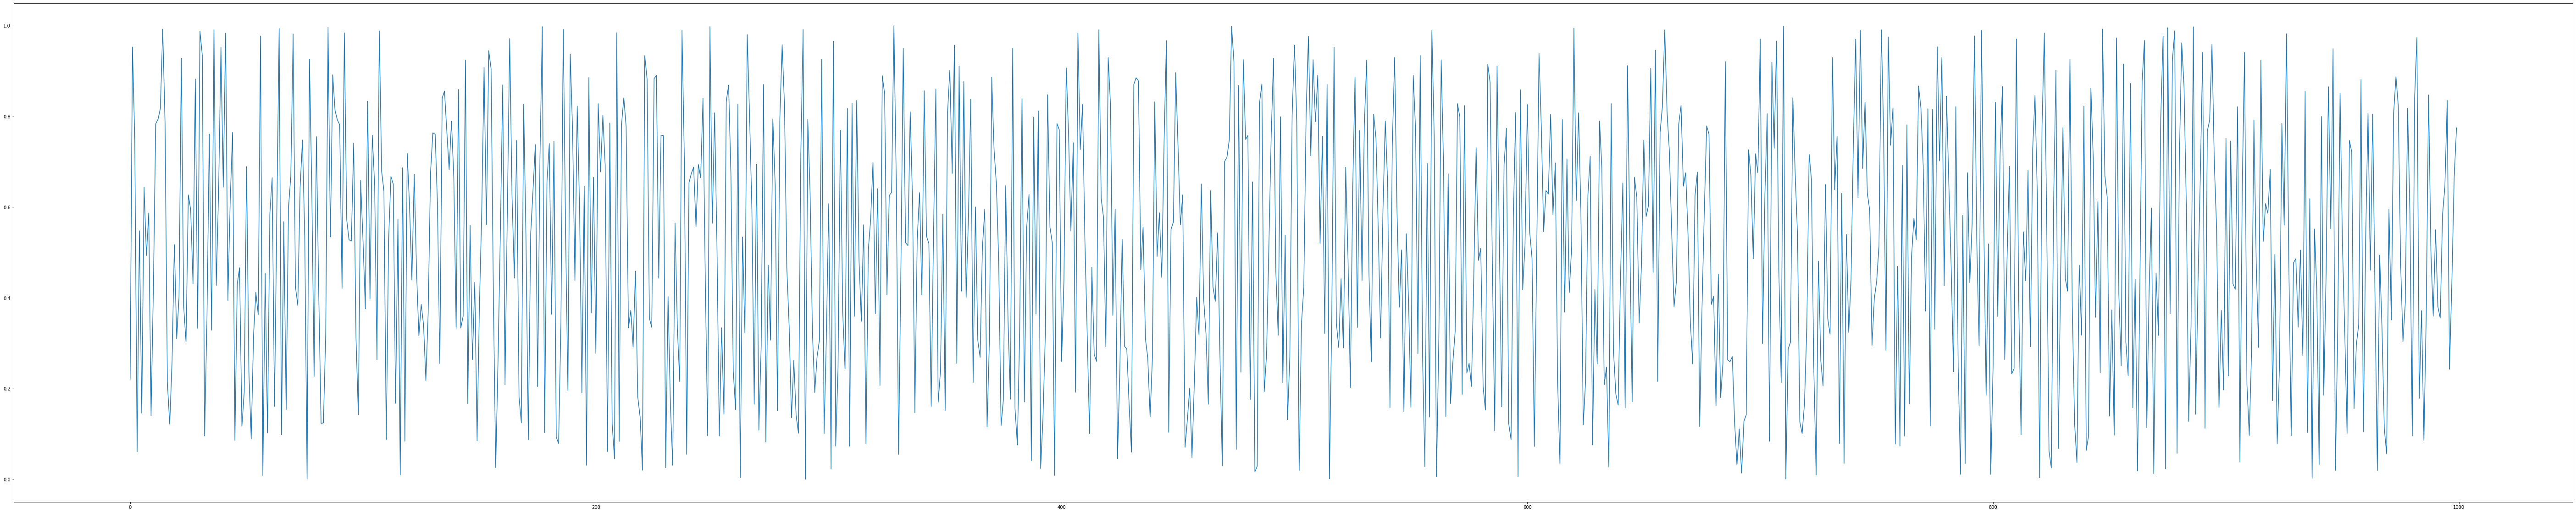

In [67]:
plt.figure(figsize=[100, 20])
plt.plot(np.arange(0, 1000), data)
plt.show()

In [65]:
from sklearn.model_selection import train_test_split

X, y 데이터 생성하기 

다음으로, 해당 샘플 데이터를 1칸씩 이동하며 10개씩 데이터를 잘라, x값으로 사용하고, y값은 11번째 데이터로 사용하겠습니다.  
예) x = 1번째 ~ 10번째 데이터 / y = 11번째

질문) 길이가 1000인 data를 이용해, 몇 쌍의 x, y 데이터를 만들어낼 수 있을까요?


In [68]:
x_sin = np.array([[[data[i+j]] for j in range(10)] for i in range(len(data)-9-1)])
y_sin = np.array([[data[i+10]] for i in range(len(data)-10)])
x_sin.shape, y_sin.shape

((990, 10, 1), (990, 1))

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(x_sin, y_sin, test_size=0.25, random_state=42)

In [69]:
# shuffle = False로 명시하면, 데이터셋 순차적으로 split
x_train, x_test, y_train, y_test = train_test_split(x_sin, y_sin, shuffle=False) 

In [70]:
x_train.shape, x_test.shape, y_train.shape

((742, 10, 1), (248, 10, 1), (742, 1))

### 모델 작성.
1. layer1: SimpleRNN 8
2. layer2: SimpleRNN 8
3. layer3: SimpleRNN 4
4. output_layer:  Dense 1 # 값이 하나 ManyToOne

In [77]:
x_train.shape

(742, 10, 1)

In [86]:
rnn = layers.SimpleRNN(8, input_shape=(10,1),  return_sequences=True,
                           name= 'rnn-1')
hidden_vec = rnn(x_train)

In [87]:
hidden_vec.shape

TensorShape([742, 10, 8])

In [88]:
model = models.Sequential()


model.add(layers.SimpleRNN(8, input_shape=(10,1), return_sequences=True, 
                           name= 'rnn-1')) 
model.add(layers.SimpleRNN(8, return_sequences=True,
                           name= 'rnn-2'))
model.add(layers.SimpleRNN(4, name= 'rnn-3')) 
model.add(layers.Dense(1)) # 5

model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
24/24 [==============================] - 2s 9ms/step - loss: 0.1929
Epoch 2/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0978
Epoch 3/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0870
Epoch 4/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0847
Epoch 5/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0839
Epoch 6/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0828
Epoch 7/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0825
Epoch 8/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0823
Epoch 9/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0820
Epoch 10/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0817


In [89]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn-1 (SimpleRNN)           (None, 10, 8)             80        
                                                                 
 rnn-2 (SimpleRNN)           (None, 10, 8)             136       
                                                                 
 rnn-3 (SimpleRNN)           (None, 4)                 52        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


- unit: 노드의 개수 (= 아웃풋 공간의 차원) = 8
- Wx + Wh + b = 8x1 + 8x8 + 8x1 = 80 (layer 1)
- Wx + Wh + b = 8x8 + 8x8 + 8x1 = 136 (layer 2)
- Wx + Wh + b = 4x8 + 4x4 + 4x1 = 52 (layer 3)

In [90]:
for model_weight in model.weights:
    print(model_weight.name, '=>', model_weight.shape)

rnn-1/simple_rnn_cell_16/kernel:0 => (1, 8)
rnn-1/simple_rnn_cell_16/recurrent_kernel:0 => (8, 8)
rnn-1/simple_rnn_cell_16/bias:0 => (8,)
rnn-2/simple_rnn_cell_17/kernel:0 => (8, 8)
rnn-2/simple_rnn_cell_17/recurrent_kernel:0 => (8, 8)
rnn-2/simple_rnn_cell_17/bias:0 => (8,)
rnn-3/simple_rnn_cell_18/kernel:0 => (8, 4)
rnn-3/simple_rnn_cell_18/recurrent_kernel:0 => (4, 4)
rnn-3/simple_rnn_cell_18/bias:0 => (4,)
dense/kernel:0 => (4, 1)
dense/bias:0 => (1,)


In [ ]:
model.weights

[<tf.Variable 'rnn-1/simple_rnn_cell_29/kernel:0' shape=(1, 8) dtype=float32, numpy=
 array([[-0.18800162, -0.29914007, -0.5839656 ,  0.30306578, -0.7608339 ,
          0.40249434,  0.12988357,  0.54060656]], dtype=float32)>,
 <tf.Variable 'rnn-1/simple_rnn_cell_29/recurrent_kernel:0' shape=(8, 8) dtype=float32, numpy=
 array([[ 0.14725368, -0.2113123 ,  0.1864713 , -0.83868945,  0.01812827,
          0.3839807 , -0.36225304, -0.1057026 ],
        [ 0.17194097,  0.6027486 , -0.35912195, -0.3158128 ,  0.20388001,
         -0.47089094, -0.24583969,  0.23321757],
        [ 0.52396065, -0.1410899 ,  0.45324275,  0.31957576,  0.02274773,
         -0.09114577, -0.5849099 ,  0.32340264],
        [-0.52324855, -0.1746197 ,  0.11323429, -0.11156499, -0.14186995,
         -0.11387154,  0.10797281,  0.837255  ],
        [-0.19559683, -0.50413114, -0.03733534, -0.1324086 ,  0.00919067,
         -0.66801727, -0.21130334, -0.3300462 ],
        [-0.31638914, -0.16781375, -0.45055503,  0.20583014,  0.

##### 학습결과

In [91]:
y_hat = model.predict(x_test) #테스트값 예측

In [93]:
y_hat.shape

(248, 1)

In [94]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train)+len(y_hat))

plt.figure(figsize = (100,30))
# Train 데이터 그래프로 표현
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o')
plt.plot(y_2_axis, y_hat.reshape(len(x_test),),'-o', color = 'red', label = 'predicted')
plt.plot(y_2_axis, y_test.reshape(len(x_test),), '-o', color = 'purple', alpha = 0.3, label = 'actual')
plt.legend(fontsize = 40)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 2. Keras로 LSTM 구현하기

https://keras.io/api/layers/recurrent_layers/lstm/

사실 실제로 SimpleRNN이 사용되는 경우는 거의 없습니다. 이보다는 LSTM이나 GRU을 주로 사용하는데, 이번에는 임의의 입력에 대해서 LSTM을 사용할 경우를 보겠습니다.

In [97]:
train_X

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]], dtype=float32)

In [98]:
lstm = LSTM(3)
output = lstm(train_X)

print('hidden state : {}, shape: {}'.format(output, output.shape))

hidden state : [[-0.23572363 -0.06817472  0.04906995]
 [-0.15629375 -0.10382952  0.12270046]], shape: (2, 3)


In [99]:
lstm = LSTM(3, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(train_X)

print('whole_seq_output: {}, shape: {}'.format(whole_seq_output, whole_seq_output.shape))
print('final_memory_state : {}, shape: {}'.format(final_memory_state, final_memory_state.shape))
print('final_carry_state : {}, shape: {}'.format(final_carry_state, final_carry_state.shape))

whole_seq_output: [[[-0.09401251 -0.02678693 -0.06398055]
  [-0.00996428 -0.05754067 -0.10897236]
  [-0.05149124  0.07591179 -0.13192868]]

 [[-0.05159465  0.12164692 -0.06898443]
  [ 0.02835426  0.05256381 -0.10637151]
  [ 0.1092376   0.02663396 -0.13275406]]], shape: (2, 3, 3)
final_memory_state : [[-0.05149124  0.07591179 -0.13192868]
 [ 0.1092376   0.02663396 -0.13275406]], shape: (2, 3)
final_carry_state : [[-0.07949872  0.14985266 -0.26178744]
 [ 0.16938233  0.07044554 -0.36880094]], shape: (2, 3)


In [100]:
from tensorflow.keras import layers, models

model = models.Sequential() #모델 호출
model.add(layers.LSTM(units=num_classes,input_shape = (sequence_length, input_dim), return_sequences = True, name='LSTM-1')) # RNN 호출
model.add(layers.Dense(units=num_classes, activation='softmax', name='hidden-to-output')) # 출력을 위한 FFN


model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'])


In [101]:
model.fit(train_X, train_Y, epochs= 100)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.0613 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 1.0540 - accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 1.0467 - accuracy: 0.6667
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 1.0393 - accuracy: 0.6667
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 1.0319 - accuracy: 0.6667
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 1.0243 - accuracy: 0.6667
Epoch 7/100
1/1 [==============================] - 0s 44ms/step - loss: 1.0167 - accuracy: 0.8333
Epoch 8/100
1/1 [==============================] - 0s 38ms/step - loss: 1.0090 - accuracy: 0.8333
Epoch 9/100
1/1 [==============================] - 0s 44ms/step - loss: 1.0012 - accuracy: 0.8333
Epoch 10/100
1/1 [==============================] - 0s 22ms/step - loss: 0.9932 - accuracy: 0.8333
Epoch 11/100
1/1 [===

In [102]:
model.predict(train_X)

array([[[0.83584225, 0.13489777, 0.02926002],
        [0.1044429 , 0.8858751 , 0.00968201],
        [0.03164825, 0.01570716, 0.9526446 ]],

       [[0.8772501 , 0.09155296, 0.03119703],
        [0.11112669, 0.87602943, 0.01284388],
        [0.02694038, 0.01015651, 0.96290314]]], dtype=float32)

In [103]:
predictions = model.predict(train_X)
for i, prediction in enumerate(predictions):
  print(prediction)
  print(np.argmax(prediction, axis=1))
  result_str = [idx2tag[c] for c in np.argmax(prediction, axis=1) ]
  print("\tPrediction str: ", "".join(result_str))


[[0.83584225 0.13489777 0.02926002]
 [0.1044429  0.8858751  0.00968201]
 [0.03164825 0.01570716 0.9526446 ]]
[0 1 2]
	Prediction str:  SVO
[[0.8772501  0.09155296 0.03119703]
 [0.11112669 0.87602943 0.01284388]
 [0.02694038 0.01015651 0.96290314]]
[0 1 2]
	Prediction str:  SVO


모델을 이해하려면 weight 개수(W0\~Wn)를 세어봐야 합니다.

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM-1 (LSTM)               (None, 3, 3)              96        
                                                                 
 hidden-to-output (Dense)    (None, 3, 3)              12        
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


- W_forget : (num_units + input_dim + 1) * num_units
- W_input : (num_units + input_dim + 1) * num_units
- W_output : (num_units + input_dim + 1) * num_units
- W_cell : (num_units + input_dim + 1) * num_units

즉, [(num_units + input_dim + 1) * num_units] * 4로 Vanila RNN의 파라미터의 4배

In [ ]:
3*(3 + 4 + 1) * 4

96

In [105]:
for model_weight in model.weights:
    print(model_weight.name, '=>', model_weight.shape)

LSTM-1/lstm_cell_2/kernel:0 => (4, 12)
LSTM-1/lstm_cell_2/recurrent_kernel:0 => (3, 12)
LSTM-1/lstm_cell_2/bias:0 => (12,)
hidden-to-output/kernel:0 => (3, 3)
hidden-to-output/bias:0 => (3,)


In [106]:
model.weights

[<tf.Variable 'LSTM-1/lstm_cell_2/kernel:0' shape=(4, 12) dtype=float32, numpy=
 array([[-0.45836863,  1.3710096 , -0.52433735,  0.22016758,  0.25705338,
         -0.18975672, -0.14872202, -0.60282075,  0.8261994 , -0.3922758 ,
         -0.5016398 ,  0.29895303],
        [ 0.59781957,  0.5360658 ,  0.5851641 , -0.8384738 ,  0.78122854,
          0.27513897, -1.4816641 , -1.1556767 , -1.1497828 ,  1.426623  ,
          1.0149459 ,  1.2208853 ],
        [ 0.7801457 ,  1.0668432 ,  0.5345385 , -0.4988808 , -0.7079036 ,
          0.9412355 ,  0.4292555 , -0.3752105 ,  0.56659085,  0.35340744,
          1.1766835 ,  1.3333477 ],
        [ 1.1077563 ,  1.2471628 ,  0.88764757, -1.4041073 , -0.7218192 ,
          0.22282292,  0.7308814 ,  0.5292378 , -0.64093906,  1.1699307 ,
          0.22808744,  0.27840236]], dtype=float32)>,
 <tf.Variable 'LSTM-1/lstm_cell_2/recurrent_kernel:0' shape=(3, 12) dtype=float32, numpy=
 array([[-1.0705796 , -0.7014593 , -0.2969861 ,  0.79657096,  1.4451008 ,
  

In [ ]:
model.weights[1]

<tf.Variable 'LSTM-1/lstm_cell_2/recurrent_kernel:0' shape=(3, 12) dtype=float32, numpy=
array([[ 0.75682914, -0.35146794, -1.007647  ,  0.693308  ,  1.4063649 ,
        -0.47902542,  0.02828962, -0.01481505, -0.84797513,  1.0669317 ,
         0.48170188, -1.3739556 ],
       [ 0.35771206, -1.4789704 , -0.5770698 ,  1.4043521 ,  1.6754783 ,
        -1.3058658 ,  0.88992065,  0.2864525 , -1.0450766 ,  1.5648375 ,
         0.44651854, -1.1294645 ],
       [ 0.9291977 ,  1.2615772 ,  0.97694826,  0.59352475,  0.06933756,
         0.47147694,  1.1340846 ,  1.1627512 ,  0.71381587,  0.66632396,
         0.18482257, -0.5577324 ]], dtype=float32)>

# 3. Keras로 GRU 구현하기

https://keras.io/api/layers/recurrent_layers/gru/

In [111]:
gru = GRU(num_classes)
output = gru(train_X)

print('hidden state : {}, shape: {}'.format(output, output.shape))

hidden state : [[-0.09182896  0.03454867  0.22038323]
 [-0.20857568 -0.06410696  0.13464828]], shape: (2, 3)


In [115]:
gru = GRU(3, return_sequences=True, return_state=True)
whole_sequence_output, final_state= gru(train_X)

print('whole_seq_output: {}, shape: {}'.format(whole_seq_output, whole_seq_output.shape))
print('final_state : {}, shape: {}'.format(final_state, final_state.shape))

whole_seq_output: [[[-0.09401251 -0.02678693 -0.06398055]
  [-0.00996428 -0.05754067 -0.10897236]
  [-0.05149124  0.07591179 -0.13192868]]

 [[-0.05159465  0.12164692 -0.06898443]
  [ 0.02835426  0.05256381 -0.10637151]
  [ 0.1092376   0.02663396 -0.13275406]]], shape: (2, 3, 3)
final_state : [[-0.01364339 -0.09752809 -0.29531503]
 [-0.1382637   0.34500766 -0.10486569]], shape: (2, 3)


In [116]:
from tensorflow.keras import layers, models

model = models.Sequential() #모델 호출
model.add(layers.GRU(units=num_classes,input_shape = (sequence_length, input_dim), return_sequences = True, reset_after=False, name='GRU-1')) # RNN 호출
# reset_after : keras 구현을 하면서 병렬처리를 위해 공식을 수정(bias를 2개로 나눔)하였는데, 원래 논문에 나온 공식으로 계산하기 위해 False로 수정

model.add(layers.Dense(units=num_classes, activation='softmax', name='hidden-to-output')) # 출력을 위한 FFN


model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'])


In [117]:
model.fit(train_X, train_Y, epochs= 100)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.1720 - accuracy: 0.3333
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 1.1633 - accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 1.1552 - accuracy: 0.1667
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 1.1476 - accuracy: 0.1667
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 1.1405 - accuracy: 0.1667
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 1.1338 - accuracy: 0.1667
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 1.1275 - accuracy: 0.1667
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 1.1215 - accuracy: 0.1667
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 1.1158 - accuracy: 0.1667
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 1.1104 - accuracy: 0.1667
Epoch 11/100
1/1 [=======

In [118]:
predictions = model.predict(train_X)
for i, prediction in enumerate(predictions):
  print(prediction)
  print(np.argmax(prediction, axis=1))
  result_str = [idx2tag[c] for c in np.argmax(prediction, axis=1) ]
  print("\tPrediction str: ", "".join(result_str))


[[0.9279804  0.04013555 0.03188401]
 [0.03927718 0.93531746 0.02540539]
 [0.06874789 0.0213469  0.9099052 ]]
[0 1 2]
	Prediction str:  SVO
[[0.8750523  0.0579103  0.06703743]
 [0.04613813 0.91858786 0.03527396]
 [0.05193312 0.01901097 0.92905587]]
[0 1 2]
	Prediction str:  SVO


모델을 이해하려면 weight 개수(W0\~Wn)를 세어봐야 합니다.

In [119]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU-1 (GRU)                 (None, 3, 3)              72        
                                                                 
 hidden-to-output (Dense)    (None, 3, 3)              12        
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


- W_reset : (num_units + input_dim + 1) * num_units
- W_update : (num_units + input_dim + 1) * num_units
- W_new : (num_units + input_dim + 1) * num_units

즉, [(num_units + input_dim + 1) * num_units] * 3으로 Vanila RNN의 파라미터의 3배

In [ ]:
3*(3 + 4 + 1) * 3

72

In [120]:
for model_weight in model.weights:
    print(model_weight.name, '=>', model_weight.shape)

GRU-1/gru_cell_5/kernel:0 => (4, 9)
GRU-1/gru_cell_5/recurrent_kernel:0 => (3, 9)
GRU-1/gru_cell_5/bias:0 => (9,)
hidden-to-output/kernel:0 => (3, 3)
hidden-to-output/bias:0 => (3,)


### reference

- https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/08.%20RNN/8-4.%20understanding_simplernn_and_lstm.ipynb